# Klassificering Titanic

## Klassificering

Klassificering med hjälp av två olika modeller för klassificering, logistiskt regression och desicion trees (som klarar såväl regression som klassificering). Vi kommer använda ett dataset som har data om överlevare från Titanic.

Det dataset vi ska använda finns i datamappen på GitHub och heter titanic_train.csv. 


### Logistisk regression för att bestämma om man överlever eller inte

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

Läs in datafilen och gör dig familiär med den. 

In [3]:
titanic = pd.read_csv("Data/titanic-train.csv") #kan se olika ut beroende på lösning med datafiler
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
titanic.nunique()


PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

### Explorativ dataanalys

För att veta vilka data som har betydelse när det handlar om att klassificera huruvida en person lever eller dör behöver vi undersöka vårt dataset med fokus på vilka variabler som påverkar `survival` som är den beroende variabel vi vill prediktera, alltså vårt y. Först behöver vi dock städa och förbereda data för analys.

Undersökning av hur många som levde och hur många som dog.

>a. Antal som överlevde och antal som dog?
>
>
>b. Hur många % överlevde?
>
>
>c. Visualisera antal överlevare och antal döda i ett stapeldiagram

In [5]:
titanic.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [6]:
titanic.Survived.value_counts(normalize=True)*100

0    61.616162
1    38.383838
Name: Survived, dtype: float64

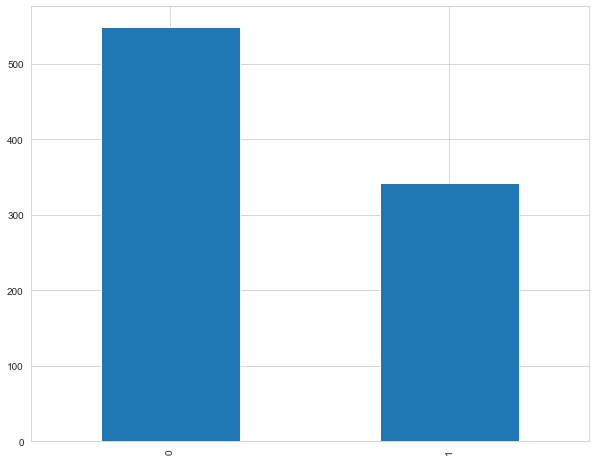

In [7]:
titanic.Survived.value_counts().plot.bar()

### Städa data, hantera nullvärden, kontrollera outliers, kontrollera typ av variabler (kategoriska, kontinuerliga, numeriska/labels)


In [8]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
#Annat alternativ 
null_values = titanic.isnull().sum()
null_values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
#Tar bort de två rader som innehåller null i Embarked 
titanic.dropna(axis=0, subset=["Embarked"],inplace=True)
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [1]:
#Kontrollerar outliers för kontinuerliga värden (bortser från ID:n de har ingen betydelse, 
#de betyder ju ingenting och kategoriska värden där begreppet inte har någon mening, 
plot_columns = ['Age','Fare']
plt.figure(figsize=(18,9))
titanic[plot_columns].boxplot()
plt.title("Continous variables in titanic dataset", fontsize=20)
plt.show()

NameError: name 'plt' is not defined

In [12]:
#Annat alternativ, beräknar z-score (högre än 3 indikerar outlier beräknas med medelvärde och standardavvikelse, 
#fungerar bara på kontinuerliga värden, på kategoriska värden finns inte riktigt begreppet outlier.

#Skapa en dataframe med numeriska värden
od_df=titanic.loc[:,['Age','Fare']]
#För varje kolumn, skapa en ny kolumn med z_score och en för potentiell outlier i enlighet med kod nedan
for col in od_df.columns:
    col_zscore = col + "_zscore"
    col_outlier = col + "_outlier"
    od_df[col_zscore] = (od_df[col] - od_df[col].mean())/od_df[col].std(ddof=0)
    od_df[col_outlier] = (od_df[col_zscore] >3).astype(int) | (od_df[col_zscore] <-3).astype(int)
od_df


,Age,Fare,Age_zscore,Age_outlier,Fare_zscore,Fare_outlier
0,22.0,7.2500,-0.527669,0,-0.500240,0
1,38.0,71.2833,0.577094,0,0.788947,0
2,26.0,7.9250,-0.251478,0,-0.486650,0
3,35.0,53.1000,0.369951,0,0.422861,0
4,35.0,8.0500,0.369951,0,-0.484133,0
...,...,...,...,...,...,...
886,27.0,13.0000,-0.182430,0,-0.384475,0
887,19.0,30.0000,-0.734812,0,-0.042213,0
888,NaN,23.4500,NaN,0,-0.174084,0
889,26.0,30.0000,-0.251478,0,-0.042213,0


In [13]:
print("number of outliers in Age " + str(od_df.Age_outlier.sum()))
print("number of outliers in Fare " + str(od_df.Fare_outlier.sum()))

number of outliers in Age 2
number of outliers in Fare 20


In [16]:
titanic.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005028,-0.035330,0.033681,-0.057686,-0.001657,0.012703
Survived,-0.005028,1.000000,-0.335549,-0.082446,-0.034040,0.083151,0.255290
Pclass,-0.035330,-0.335549,1.000000,-0.365902,0.081656,0.016824,-0.548193
Age,0.033681,-0.082446,-0.365902,1.000000,-0.307351,-0.187896,0.093143
SibSp,-0.057686,-0.034040,0.081656,-0.307351,1.000000,0.414542,0.160887
Parch,-0.001657,0.083151,0.016824,-0.187896,0.414542,1.000000,0.217532
Fare,0.012703,0.255290,-0.548193,0.093143,0.160887,0.217532,1.000000


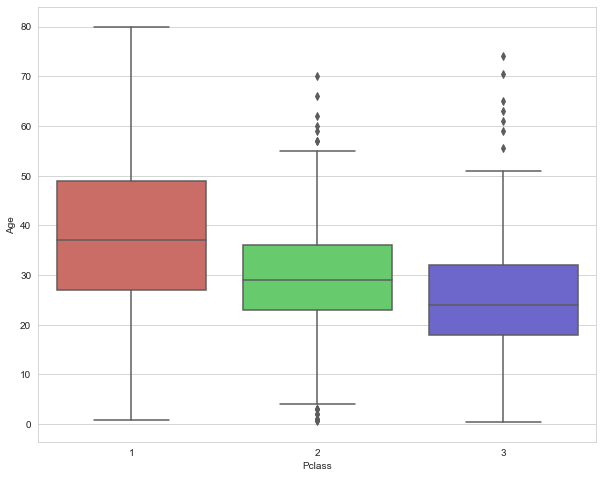

In [17]:
sb.boxplot(x='Pclass', y='Age', data=titanic, palette='hls')

In [18]:
class3_titanic = titanic[titanic['Pclass'] == 3] 
print('Tredjeklass median:', class3_titanic.Age.median())
print('Tredjeklass mean:', class3_titanic.Age.mean())
class2_titanic = titanic[titanic['Pclass'] == 2] 
print('Andraklass median:', class2_titanic.Age.median())
print('Andraklass mean:', class2_titanic.Age.mean())
class1_titanic = titanic[titanic['Pclass'] == 1] 
print('Förstaklass median:', class1_titanic.Age.median())
print('Förstaklass mean:', class1_titanic.Age.mean())

Tredjeklass median: 24.0
Tredjeklass mean: 25.14061971830986
Andraklass median: 29.0
Andraklass mean: 29.87763005780347
Förstaklass median: 37.0
Förstaklass mean: 38.10554347826087


In [19]:
#Funktion för att ersätta nullvärden med approximerade värden 
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 36
        elif Pclass == 2:
            return 29
        else:
            return 27
    else:
        return Age

In [20]:
titanic_fill_null_class_m =titanic.copy()
null_values = titanic_fill_null_class_m.isnull().sum()
null_values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [21]:
#Ersätt med relevant ålder beroende på korrelerad variabel. OBS! Inget är ändrat i originalet, detta måste göras innan man kan använda kolumnen! 
titanic_fill_null_class_m = titanic.copy()
titanic_fill_null_class_m ['Age'] = titanic_fill_null_class_m [['Age', 'Pclass']].apply(age_approx, axis=1)
titanic_fill_null_class_m.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [26]:
#Ersätter kolumnen age i titanic med den nya age i titanic_fill_null_class_m
titanic.Age=titanic_fill_null_class_m.Age
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Cabin          202 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 130.3+ KB


In [27]:
#Drop
titanic=titanic.drop("Cabin", axis=1)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 123.3+ KB


In [28]:
#tar bort de två rader som innehåller null i Embarked
titanic.dropna(inplace=True)
titanic.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

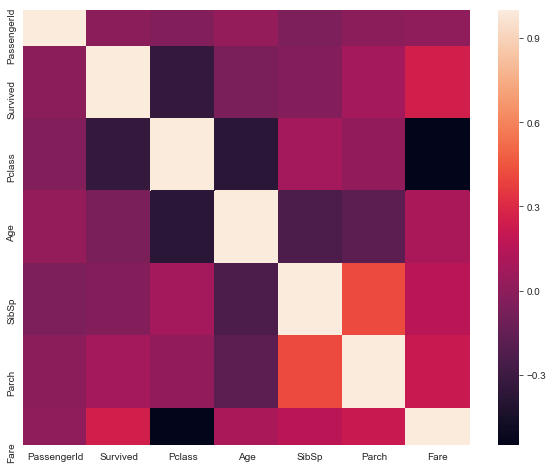

In [30]:
#korrelationsanalys
sb.heatmap(titanic.corr())  

In [31]:
#Ta bort kolumner som inte ska användas
columns_to_drop= ["Pclass","Parch","Name","PassengerId", "Ticket"]
titanic_log_reg=titanic.drop(columns_to_drop, axis=1)
titanic_log_reg

,Survived,Sex,Age,SibSp,Fare,Embarked
0,0,male,22.0,1,7.2500,S
1,1,female,38.0,1,71.2833,C
2,1,female,26.0,0,7.9250,S
3,1,female,35.0,1,53.1000,S
4,0,male,35.0,0,8.0500,S
...,...,...,...,...,...,...
886,0,male,27.0,0,13.0000,S
887,1,female,19.0,0,30.0000,S
888,0,female,27.0,1,23.4500,S
889,1,male,26.0,0,30.0000,C


In [32]:
#Ersätter kategorisk data med dummy-data för sex
titanic_log_reg = pd.get_dummies(titanic_log_reg, columns=['Sex'], drop_first=True)
titanic_log_reg

,Survived,Age,SibSp,Fare,Embarked,Sex_male
0,0,22.0,1,7.2500,S,1
1,1,38.0,1,71.2833,C,0
2,1,26.0,0,7.9250,S,0
3,1,35.0,1,53.1000,S,0
4,0,35.0,0,8.0500,S,1
...,...,...,...,...,...,...
886,0,27.0,0,13.0000,S,1
887,1,19.0,0,30.0000,S,0
888,0,27.0,1,23.4500,S,0
889,1,26.0,0,30.0000,C,1


In [33]:
#samma sak med Embarked
titanic_log_reg = pd.get_dummies(titanic_log_reg, columns=['Embarked'], drop_first=True)
titanic_log_reg

,Survived,Age,SibSp,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,22.0,1,7.2500,1,0,1
1,1,38.0,1,71.2833,0,0,0
2,1,26.0,0,7.9250,0,0,1
3,1,35.0,1,53.1000,0,0,1
4,0,35.0,0,8.0500,1,0,1
...,...,...,...,...,...,...,...
886,0,27.0,0,13.0000,1,0,1
887,1,19.0,0,30.0000,0,0,1
888,0,27.0,1,23.4500,0,0,1
889,1,26.0,0,30.0000,1,0,0


In [34]:
titanic_log_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 7 columns):
Survived      889 non-null int64
Age           889 non-null float64
SibSp         889 non-null int64
Fare          889 non-null float64
Sex_male      889 non-null uint8
Embarked_Q    889 non-null uint8
Embarked_S    889 non-null uint8
dtypes: float64(2), int64(2), uint8(3)
memory usage: 37.3 KB


In [ ]:
#Skapa och träna modell

X = titanic_log_reg.iloc[:,[1,2,3,4,5,6]]
y = titanic_log_reg.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #20% test size - rest training
print("Training has {} rows".format(len(X_train)))
print("Test has {} rows".format(len(X_test)))

LogReg = LogisticRegression() 
LogReg.fit(X_train, y_train)


In [ ]:
data = {'Sex_male': [0],
        'Age': [34],
        'SibSp': [1]}

#Skapa DF
sann_df = pd.DataFrame(data) 

#Kolla sannolikhet
sannolikhet = sann_df.copy()
sannolikhet['Survived'] = LogReg.predict(sann_df)
print(sannolikhet)

y_pred_surv = LogReg.predict_proba(sann_df)
print(y_pred_surv)

In [ ]:
#testa modell på testdata
y_pred = LogReg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(LogReg.score(X_test, y_test)))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print(classification_report(y_test, y_pred))

### Desicion trees för att bestämma vilka som överlever

Vi ska också testa att använda ett beslutsträd för att bestämma vilka som överlever.

In [ ]:
from graphviz import Source 
from sklearn.tree import export_graphviz 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [ ]:
#Skapar df för beslutsträdet som har andra X
columns_to_drop= ["Pclass","Parch","Name","PassengerId", "Ticket", "Embarked"]
#titanic_DT=titanic.drop(columns_to_drop, axis=1)
titanic_DT

In [ ]:
titanic_DT= pd.get_dummies(titanic_DT, columns=['Sex'], drop_first=True)
titanic_DT

In [ ]:
y_DT = titanic_DT.Survived #detta motsvarar y
X_DT = titanic_DT[['Sex_male', 'Fare', 'Age', 'SibSp']] #motsvarar X
titanic_DT.info()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_DT, y_DT, test_size=0.25)
print("Our training data has {} rows".format(len(X_train)))
print("Our test data has {} rows".format(len(X_test)))

In [ ]:
classifier = DecisionTreeClassifier(max_depth=3)
classifier.fit(X_train.values, y_train.values)

In [ ]:
y_pred = classifier.predict(X_test.values)

In [ ]:
#Hur många män/kvinnor överlever predikterat på 10 rader. 
test = X_test.head(10).copy()
test['Pred_Survived'] = classifier.predict(test)
test

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test.values, y_pred)
confusion_matrix

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
tree_plot = Source(tree.export_graphviz(classifier, out_file=None, 
                            feature_names=X_train.columns, class_names=['Dead', 'Alive'], 
                            filled=True, rounded=True, special_characters=True))
tree_plot